# Multi-agent - Tribal

The Gathering Game is a miniworld composed of:
* Agents (Gatherers)
* Resource (Food units) - a source of positive rewards provided by the environment
* Weaponry (Laser) - the ability of agents to inflict negative reward on other agents

The way we organize the rewards of the agents can transform the game and the problem:
* **A world of individual beings** - It is equivalent to a world with a horse, a sheep, a hog, etc. There can be neither context nor reason for them to cooperate for the common good. Cooperation has to come about due to selfishness and reciprocity.
* **A world of communal beings** - Rewards are to some extent shared. Cooperation comes about due to the need to maximize total reward.
* **A world of competing tribes** - It is equivalent to a world of tribes. All rewards gathered by a tribe are shared within by tribe members. Cooperation within tribe comes about due to the need to maximize total reward for the tribe. Cooperation between tribes still has to come about due to selfishness.

In this Notebook, we will implement:
1. Tribal beings - changing the way the agents view themselves as "us' versus "them". 
2. Tribal organization - using intra-tribe rewards to shape the learnings of agents towards specialization.

## GYM and PYTORCH Versions

**OpenAI Gym version: 0.9.2**  
We discovered that latest OpenAI Gym (version 0.9.3 and above) screwed up MultiDiscrete implementation in the GatheringEnv class, so we have to revert back to Version 0.9.2.



In [2]:
import os
import random
import time
import platform
import torch
import gym
import numpy as np

# This is the Gathering Game Environment based on Tribal Organization of agents
from commune_env import GatheringEnv
from commune_model import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


### Rewrite GatheringEnv

A big barrier for agents to adopt Tribal Organization is their inability to distinguish between "US" versus "THEM".

Our solution is to add more frames into the observations returned by GatheringEnv:

The observation for each agent will now be a stack of 6 frames of 10x20 pixels. These 4 frames identifies:
1. Location of Food
2. Location of agents of the same tribe (US) in the viewbox
3. Location of agents not of the same tribe (THEM) in the view box
4. Location of agents of the same tribe (US) in the lasertag box
5. Location of agents not of the same tribe (THEM) in the lasertag box
6. Location of the walls

The GatheringEnv will also return additional information which can be used by the Tribe to make decisions about awarding intra-tribe reward to its members:
1. number of agents of the same tribe that have been lasertagged
2. number of agents not of the same tribes that have been lasertagged


In [2]:
import torch


class Policy(torch.nn.Module):
    """
    First implement 2 layer NN to identify bug in training code. The Policy accepts
    Input of dimension [1,800]
    
    Later....
    will implement a 3-layer convolutional network for a specific agent
    identified by agent_inx. We comment out the LSTM implementation for now!
    """

    def __init__(self, input_channels, num_actions, agent_idx=1):
        super(Policy, self).__init__()
        self.temperature = 1.0               # This is to adjust exploit/explore 
        
        self.input_channels = input_channels
        self.num_actions = num_actions
        
        self.features = self._init_features()
        self.action_head = self._init_action_head()
        
        # Deactivate actor-critic (CNN-LSTM) for now
        # self.lstm = self._init_lstm()
        # self.action_head = self._init_action_head()
        # self.value_head = self._init_value_head()

        self.saved_actions = []
        self.rewards = []
        self.log_probs = []   # Added to implement REINFORCE for PyTorch 0.4.1
        self.idx = agent_idx   # This allows multiple learning agents
        

    def _init_features(self):
        
        layers = []
        
        # Input [1,800]
        layers.append(torch.nn.Linear(800, 128))
        # input [1,128]
        layers.append(torch.nn.ReLU(inplace=True))
        # Output [1,128]
        
        """
        # in_channels x 10 x 20 initial dimensions 3D array
        layers.append(torch.nn.Conv2d(self.input_channels,
                                      16, kernel_size=3, stride=1, padding=1))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # 16 x 10 x 20 feature maps
        layers.append(torch.nn.Conv2d(16,
                                      16, kernel_size=4, stride=2, padding=1))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # 16 x 5 x 10 feature maps
        layers.append(torch.nn.Conv2d(16,
                                      16, kernel_size=3, stride=1, padding=0))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # 16 x 3 x 8 feature maps
        """

        return torch.nn.Sequential(*layers)

    def _init_action_head(self):
        # input [1,128]
        return torch.nn.Linear(128, self.num_actions)   # output [1,8]
    
    """
    # Disable CNN-LSTM actor critic for now

    def _init_lstm(self):
        return torch.nn.LSTMCell(32*4*4, 256)

    def _init_action_head(self):
        return torch.nn.Linear(256, self.num_actions)

    def _init_value_head(self):
        return torch.nn.Linear(256, 1)
    """

        
    # The weights should be allowed to be saved into and load from agent-indexed model files
    # e.g. agent-1-model.pkl, agent-2-model.pkl, etc.
    def save_weights(self):
        file_name = 'agent-'+str(self.idx)+'-model.pkl'
        torch.save(self.state_dict(), file_name)   

    def load_weights(self):
        file_name = 'agent-'+str(self.idx)+'-model.pkl'
        if not os.path.exists(file_name):
                raise ValueError('map not found: ' + file_name)
        self.load_state_dict(torch.load(file_name))
        
    
    def forward(self, inputs):
        x = inputs
        # Try 2 layer NN for now
        x = x.view(x.size(0), -1)
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 1 x 384(16x3x8)

        """
        # Disable CNN-LSTM actor critic for now
        
        x, (hx, cx) = inputs
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 1 x 512(4x4x32)
        
        hx, cx = self.lstm(x, (hx, cx))
        x = hx
        

        value = self.value_head(x)
        return action, value, (hx, cx)       
        
        """
        probs = torch.nn.functional.softmax(self.action_head(x) /
                                             self.temperature, dim=-1)
        return probs
    

# Just a dumb random agent
class Rdn_Policy():
    def __init__(self):
        super(Rdn_Policy, self).__init__()

    def select_action(self, state):
        return random.randrange(0, 8)

Max. Running Reward - MA0 2-layer NN: 77.394
Episode achieving max. Running Reward: 496


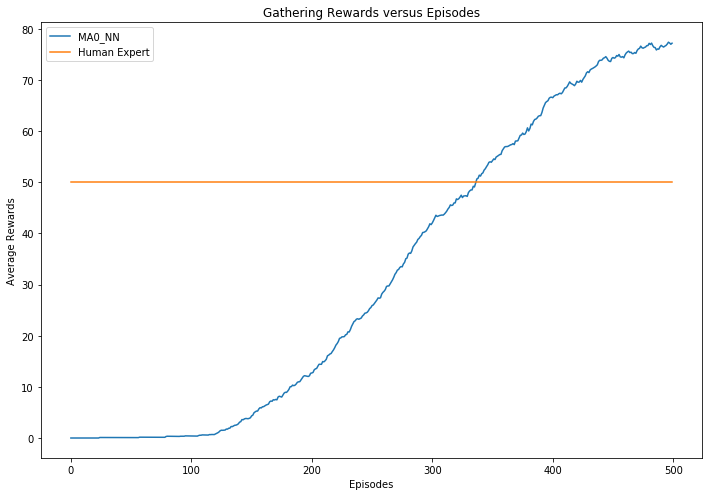

In [21]:
human_scores = {'Gathering': 50}
game = 'Gathering'

   
data_file = './results/MA0_Gather_NN.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)


print('Max. Running Reward - MA0 2-layer NN: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))

human = [human_scores[game] for _ in range(len(data_1))]

plt.figure(figsize=(10, 7))
plt.plot(data_1, label='MA0_NN')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

### CNN Policy Class

We next move to CNN with CUDA.


In [3]:
import torch


class Policy(torch.nn.Module):
    """
    We implement a 3-layer convolutional network for a specific agent
    identified by agent_inx. We comment out the LSTM implementation for now!
    """

    def __init__(self, input_channels, num_actions, agent_idx=1):
        super(Policy, self).__init__()
        self.temperature = 1.0               # This is to adjust exploit/explore 
        
        self.input_channels = input_channels
        self.num_actions = num_actions
        
        self.features = self._init_features()
        self.action_head = self._init_action_head()
        
        # Deactivate actor-critic (CNN-LSTM) for now
        # self.lstm = self._init_lstm()
        # self.action_head = self._init_action_head()
        # self.value_head = self._init_value_head()

        self.saved_actions = []
        self.rewards = []
        self.log_probs = []   # Added to implement REINFORCE for PyTorch 0.4.1
        self.idx = agent_idx   # This allows multiple learning agents
        

    def _init_features(self):
        
        layers = []
        
        # [1,4,10,20] input 3D array
        layers.append(torch.nn.Conv2d(self.input_channels,
                                      16, kernel_size=3, stride=1, padding=1))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # [1,16,10,20] feature maps
        layers.append(torch.nn.Conv2d(16,
                                      16, kernel_size=4, stride=2, padding=1))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # [1,16,5,10] feature maps
        layers.append(torch.nn.Conv2d(16,
                                      16, kernel_size=3, stride=1, padding=0))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # [1,16,3,8] feature maps

        return torch.nn.Sequential(*layers)

    def _init_action_head(self):
        # input [1,384]
        return torch.nn.Linear(384, self.num_actions)   # output [1,8]
    
    """
    # Disable CNN-LSTM actor critic for now

    def _init_lstm(self):
        return torch.nn.LSTMCell(32*4*4, 256)

    def _init_action_head(self):
        return torch.nn.Linear(256, self.num_actions)

    def _init_value_head(self):
        return torch.nn.Linear(256, 1)
    """

        
    # The weights should be allowed to be saved into and load from agent-indexed model files
    # e.g. agent-1-model.pkl, agent-2-model.pkl, etc.
    def save_weights(self):
        file_name = 'agent-'+str(self.idx)+'-model.pkl'
        torch.save(self.state_dict(), file_name)   

    def load_weights(self):
        file_name = 'agent-'+str(self.idx)+'-model.pkl'
        if not os.path.exists(file_name):
                raise ValueError('map not found: ' + file_name)
        self.load_state_dict(torch.load(file_name))
        
    
    def forward(self, inputs):
        x = inputs
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 1 x 384(16x3x8)

        """
        # Disable CNN-LSTM actor critic for now
        
        x, (hx, cx) = inputs
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 1 x 512(4x4x32)
        
        hx, cx = self.lstm(x, (hx, cx))
        x = hx
        

        value = self.value_head(x)
        return action, value, (hx, cx)       
        
        """
        probs = torch.nn.functional.softmax(self.action_head(x) /
                                             self.temperature, dim=-1)
        return probs
    

# Just a dumb random agent
class Rdn_Policy():
    def __init__(self):
        super(Rdn_Policy, self).__init__()

    def select_action(self, state):
        return random.randrange(0, 8)

### Preprocessing Observations

Gathering is a partially-observable Markov Game. state_n returned by GatheringEnv is a numpy array of dimension (num_agent, 800), which represents the agents' observations of the game.

The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format(viewbox_width, viewbox_depth, 4). 
These 4 frames currently identifiy:

1. Location of Food
2. TBD
3. Location of agents (other than the observing agent itself)
4. Location of the walls

when they are in the field of view of the agent. The 10x20 view_box include location of the observing agent:

![image](images\Viewbox.png)

We need to reprocess these raw observations into a data structure that will be accepted by the new Policy Class, which accepts (batch_idx, in_channel,  width, height).



### Dimension Check

For building the Policy architecture.

Try to get 2 layer NN working first.

In [38]:
model = Policy(4,8,1)  # 4 in_channel, 8 actions, agent_idx=1
print (model)

obs = []

env = GatheringEnv(n_agents=4, map_name='default')
state_n = env.reset()    # state_n is numpy array of dim (4, 800)  

for i in range(4):
    x = state_n[i]   # observation of the indexed agent is numpy array of dim (800,) 
    x = torch.Tensor(x)   # Convert to tensor of torch.Size([800])
    x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
    x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stack frames
    obs.append(x)
    
print (obs[1].shape)       # obs is tensor of torch.Size([1, 800])
action = model(obs[1])        # Feed observation of agent through the model! 
print (action.shape)      # action is tensor of torch.Size([1, 8])

Policy(
  (features): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
  )
  (action_head): Linear(in_features=384, out_features=8, bias=True)
)
torch.Size([1, 4, 10, 20])
torch.Size([1, 8])


## Play

In the next 2 code blocks, we will successively discard HumanCompatibleAI's code in demo.py and reinforce.py.

First we implement the code for game playing based on the visualize.py I implemented previously for Atari single-agent RL.


In [31]:
import pickle

import torch
from torch.autograd import Variable

import numpy as np

dir_name = 'MA_models/MA_4L1R_Coop/'
episodes = 5000  # This is used to recall a model file trained to a # of episodes

# There will be 5 agents - 3 AI agents, 2 random agents
num_ai_agents = 4
num_rdn_agents = 1
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two
agent_colors = ['red','red','red','red','yellow']

# Data structure for AI agents (agents will form their own Class later on)
ai_agents = []
actions = []
tags = []
rewards = []

# Initialize environment
render = True
# 5 agents, used map defined in default.txt
env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors,map_name='default')    
num_actions = 8                       # There are 8 actions defined in Gathering

# Initialize constants
num_frames = 4
max_episodes = 1
max_frames = 1000

def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""

def select_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 
# Initialize model
if episodes > 0:
    ai_agents= [[] for i in range(num_ai_agents)]
    # If episodes is provided (not 0), load the model for each AI agent
    for i in range(num_ai_agents):
        model_file = dir_name+'MA{}_Gather_ep_{}.p'.format(i,episodes)
        try:
            with open(model_file, 'rb') as f:
                # Model File include both model and optim parameters
                saved_model = pickle.load(f)
                ai_agents[i], _ = saved_model
                print("Load saved model for agent {}".format(i))
        except OSError:
            print('Model file not found.')
            raise

else:
    # If episodes=0, start with a freshly initialized model for each AI agent
    for i in range(num_ai_agents):
        print("Load agent {}".format(i))
        ai_agents.append(Policy(num_frames, num_actions, i+1))

        

# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load agent {}".format(i))
    ai_agents.append(Rdn_Policy())

# Initialize AI and random agent data
for i in range(num_agents):
    actions = [0 for i in range(num_agents)]
    tags = [0 for i in range(num_agents)]
    rewards = [0 for i in range(num_agents)]
    
for ep in range(max_episodes):

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        env.render()
        time.sleep(1/20)  # Change speed of video rendering

        for i in range(num_ai_agents):    # For AI agents
            actions[i], _ = select_action(ai_agents[i], agents_obs[i], cuda=False)
            if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                tags[i] += 1   # record a tag for accessing aggressiveness
                
        for i in range(num_ai_agents, num_agents):   # For random agents
            actions[i] = ai_agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
                
    
        
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
            
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """
        for i in range(num_agents):
            rewards[i] += reward[i]    # Accumulate rewards for each agent

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of all agents
for i in range(num_agents):
    print ("Agent{} aggressiveness is {:.2f}".format(i+1, tags[i]/frame))
    print ("Agent{} reward is {:d}".format(i+1, rewards[i]))
            


Load saved model for agent 0
Load saved model for agent 1
Load saved model for agent 2
Load saved model for agent 3
Load agent 4
Agent1 aggressiveness is 0.28
Agent1 reward is 80
Agent2 aggressiveness is 0.58
Agent2 reward is 55
Agent3 aggressiveness is 0.02
Agent3 reward is 130
Agent4 aggressiveness is 0.07
Agent4 reward is 83
Agent5 aggressiveness is 0.13
Agent5 reward is 0


## Train Workflow

The code for training multiple AI agents is based on the actor_critic_lstm-episode.py I implemented previously for Atari single-agent RL. We need to pay attention to data going in and out of Policy (which will run on GPU) having them go through rigorous conversion into and out of Tensor.

The training code is split into 2. The code finish_episode() is where the reward structure of the agents are modified to shape their behavior. 

The training work process:

* Step 1 - Modify the agent reward structure in finish_episode(), run the code block
* Step 2 - Execute the training code block - wait for models and results to be generated
* Step 3 - Run the display code block to get results. Also run the Play code section to observe agent behaviors.

## Agents with Individual Rewards

Here we have each agent learn based only on the reward it gathers from the environment. This is the Lone Wolf mode.

In [4]:
# This is the task list to finish a game episode. For now, a separate policy update is performed
# for each agent based on the history of its rewards and log_probs accumulated during an episode.
# the future, this may change - e.g. the rewards may be the averaged sum of the rewards of all 
# agents within a team.
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]

    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r in learners[i].rewards[::-1]:
            R = r + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norm = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        del learners[i].rewards[:]
        del learners[i].saved_actions[:]

    return total_norm


## 2 Agents - Individual Reward

When 2 agents are trained together each with individual reward. One player appears to dominate over the other as training progress.

Max. Running Reward - MA0 3-layer CNN: 87.964
Episode achieving max. Running Reward: 4975
Max. Running Reward - MA1 3-layer CNN: 57.165
Episode achieving max. Running Reward: 887
Max. Total Reward - MA1 + MA2: 111.443


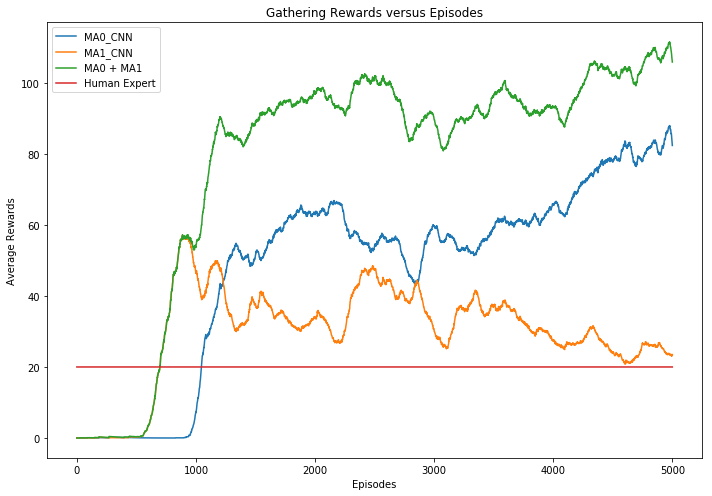

In [7]:
human_scores = {'Gathering': 20}
game = 'Gathering'

dir_name = "results/MA_2L1R_Indv/"

data_file = dir_name+'MA0_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_0 = pickle.load(f)
   
data_file = dir_name+'MA1_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

total = [sum(x) for x in zip(data_0,data_1)]

print('Max. Running Reward - MA0 3-layer CNN: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA1 3-layer CNN: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Max. Total Reward - MA1 + MA2: {:.3f}'.format(max(total)))

human = [human_scores[game] for _ in range(len(data_0))]

plt.figure(figsize=(10, 7))
plt.plot(data_0, label='MA0_CNN')
plt.plot(data_1, label='MA1_CNN')
plt.plot(total, label='MA0 + MA1')


plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## 2 Agents - Team Reward

We will change the reward structure so that the agent learn based on the rewards received by the team (the sum of both agent's rewards).

agent_reward = team_reward  
team_reward = sum(all agent_reward)  

In [ ]:
# This is the task list to finish a game episode. For now, a separate policy update is performed
# for each agent based on the history of its rewards and log_probs accumulated during an episode.
# the future, this may change - e.g. the rewards may be the averaged sum of the rewards of all 
# agents within a team.
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    
    share = [0 for i in range(len(learners[0].rewards))]
    # print (share)
    
    for i in range(num_learners):
        share = [share[j] + learners[i].rewards[j] for j in range(len(share))]
        # print (share)
    
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r in share[::-1]:
            R = r + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norm = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        del learners[i].rewards[:]
        del learners[i].saved_actions[:]

    return total_norm


## Team Reward - does not Work!!!

Free Loader problem - one of the player will do nothing!!!

Max. Running Reward - MA0 3-layer CNN: 3.492
Episode achieving max. Running Reward: 488
Max. Running Reward - MA1 3-layer CNN: 114.766
Episode achieving max. Running Reward: 4108


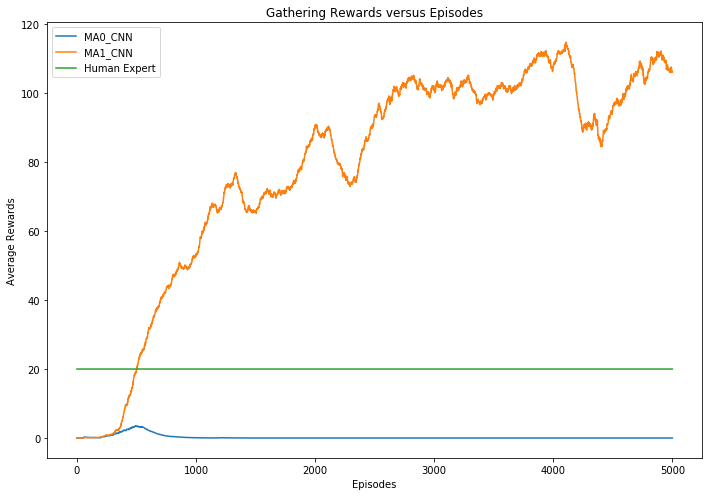

In [9]:
human_scores = {'Gathering': 20}
game = 'Gathering'
dir_name = "results/MA_2L1R_SumReward/"

data_file = dir_name+'MA0_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_0 = pickle.load(f)

   
data_file = dir_name+'MA1_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

print('Max. Running Reward - MA0 3-layer CNN: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA1 3-layer CNN: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))


human = [human_scores[game] for _ in range(len(data_0))]

plt.figure(figsize=(10, 7))
plt.plot(data_0, label='MA0_CNN')
plt.plot(data_1, label='MA1_CNN')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Multiple agent - Cooperate Incentive

Having the agents learn by backpropping team reward leads to free-loading, where one or several of the agents just stop doing anything and wait for reward to come their way from the other agents that do all the work.

So we implemented the **Cooperate Incentive** instead:

agent_reward = agent_reward + coop  
coop = min(agent_reward x coop_rate, team_reward/num_learners x 0.2)  

If coop_rate is 30%, the agent is responsible for 70% of the reward he earns, while how the team does as a whole can boost its reward by a further 30%.

In [16]:
# This is the task list to finish a game episode. For now, a separate policy update is performed
# for each agent based on the history of its rewards and log_probs accumulated during an episode.
# the future, this may change - e.g. the rewards may be the averaged sum of the rewards of all 
# agents within a team.
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    coop_rate = 0.1

    # Calculate team reward
    T_reward = [0 for i in range(len(learners[0].rewards))]
    # print (share)
    for i in range(num_learners):
        T_reward = [T_reward[j] + learners[i].rewards[j] for j in range(len(T_reward))]
        # print (share)
    
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # incentive for cooperating is limited at 0.3 of individual reward and 0.2
            # of average team member reward
            coop = min(r * coop_rate,T/num_learners * 0.2)    
            R = r + coop + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norm = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        del learners[i].rewards[:]
        del learners[i].saved_actions[:]

    return total_norm


## Coop_rate = 10%


Max. Running Reward - MA0 coop_rate=30%: 76.500
Episode achieving max. Running Reward: 1662
Max. Running Reward - MA1 coop_rate=30%: 61.854
Episode achieving max. Running Reward: 4456
Max. Total Reward - MA1 + MA2: 125.157


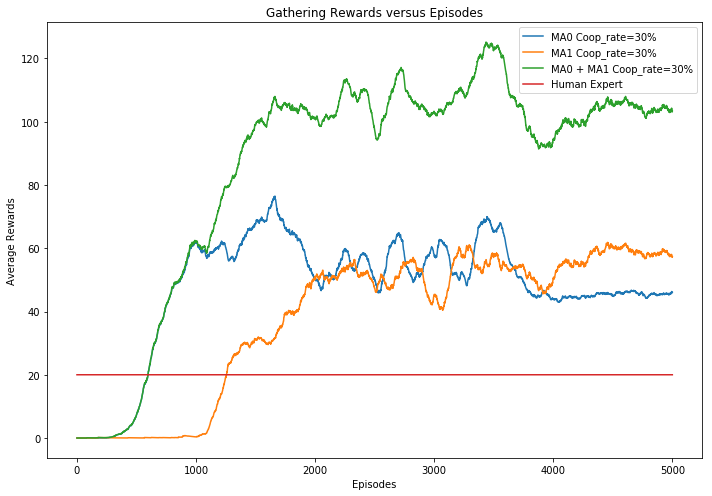

In [19]:
human_scores = {'Gathering': 20}
game = 'Gathering'
dir_name = "results/MA_2L1R_CR=0.1/"

data_file = dir_name+'MA0_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_0 = pickle.load(f)

data_file = dir_name+'MA1_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

total = [sum(x) for x in zip(data_0,data_1)]

print('Max. Running Reward - MA0 coop_rate=30%: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA1 coop_rate=30%: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Max. Total Reward - MA1 + MA2: {:.3f}'.format(max(total)))

human = [human_scores[game] for _ in range(len(data_0))]

plt.figure(figsize=(10, 7))
plt.plot(data_0, label='MA0 Coop_rate=30%')
plt.plot(data_1, label='MA1 Coop_rate=30%')
plt.plot(total, label='MA0 + MA1 Coop_rate=30%')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Coop_rate = 30%


Max. Running Reward - MA0 coop_rate=30%: 108.788
Episode achieving max. Running Reward: 2937
Max. Running Reward - MA1 coop_rate=30%: 58.634
Episode achieving max. Running Reward: 4197
Max. Total Reward - MA1 + MA2: 134.760


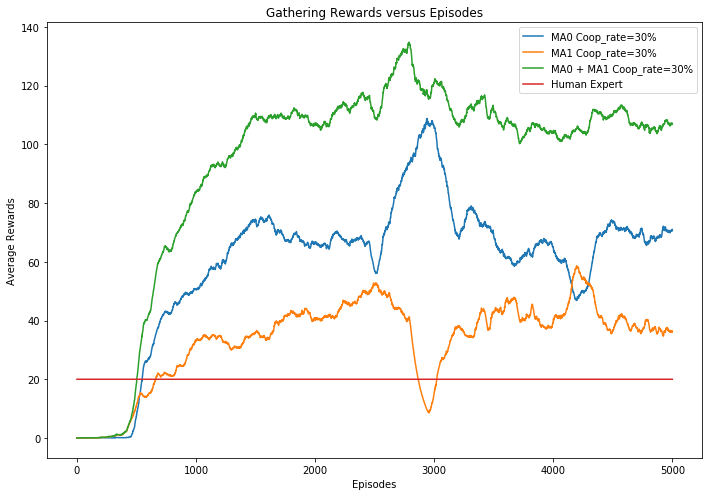

In [10]:
human_scores = {'Gathering': 20}
game = 'Gathering'
dir_name = "results/MA_2L1R_Coop/"

data_file = dir_name+'MA0_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_0 = pickle.load(f)

data_file = dir_name+'MA1_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

total = [sum(x) for x in zip(data_0,data_1)]

print('Max. Running Reward - MA0 coop_rate=30%: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA1 coop_rate=30%: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Max. Total Reward - MA1 + MA2: {:.3f}'.format(max(total)))

human = [human_scores[game] for _ in range(len(data_0))]

plt.figure(figsize=(10, 7))
plt.plot(data_0, label='MA0 Coop_rate=30%')
plt.plot(data_1, label='MA1 Coop_rate=30%')
plt.plot(total, label='MA0 + MA1 Coop_rate=30%')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Coop_rate = 50%


Max. Running Reward - MA0 coop_rate=50%: 75.176
Episode achieving max. Running Reward: 2702
Max. Running Reward - MA1 coop_rate=50%: 49.738
Episode achieving max. Running Reward: 837
Max. Total Reward - MA1 + MA2: 108.415


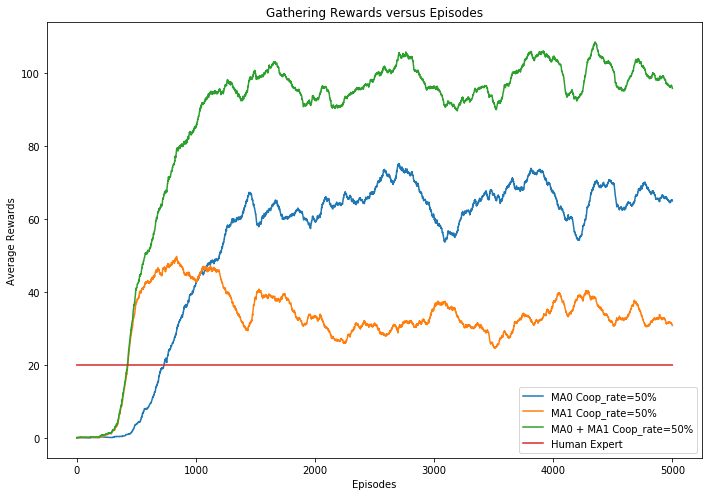

In [11]:
human_scores = {'Gathering': 20}
game = 'Gathering'
dir_name = "results/MA_2L1R_Coop1/"

data_file = dir_name+'MA0_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_0 = pickle.load(f)

data_file = dir_name+'MA1_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

total = [sum(x) for x in zip(data_0,data_1)]

print('Max. Running Reward - MA0 coop_rate=50%: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA1 coop_rate=50%: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Max. Total Reward - MA1 + MA2: {:.3f}'.format(max(total)))

human = [human_scores[game] for _ in range(len(data_0))]

plt.figure(figsize=(10, 7))
plt.plot(data_0, label='MA0 Coop_rate=50%')
plt.plot(data_1, label='MA1 Coop_rate=50%')
plt.plot(total, label='MA0 + MA1 Coop_rate=50%')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Coop_rate = 70%

As coop_rate --> 100%, there is more and more free-loading problems. In the graph below, once the reward generated by one of the agent accounts for the majority of the team reward, the other agent stops learning. It is only at a much later point in time, when the agent who has stopped learning starts learning again, likely due to explore/exploit dynamic.

Max. Running Reward - MA0 coop_rate=70%: 45.469
Episode achieving max. Running Reward: 4999
Max. Running Reward - MA1 coop_rate=70%: 104.775
Episode achieving max. Running Reward: 2955
Max. Total Reward - MA1 + MA2: 104.778


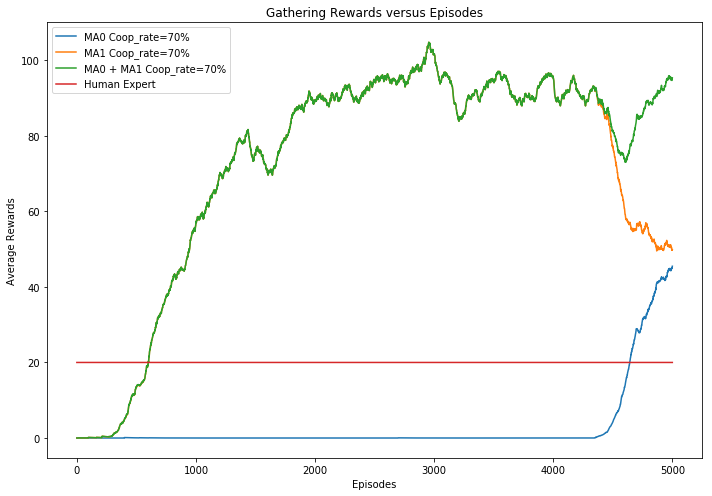

In [15]:
human_scores = {'Gathering': 20}
game = 'Gathering'
dir_name = "results/MA_2L1R_Coop2/"

data_file = dir_name+'MA0_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_0 = pickle.load(f)

data_file = dir_name+'MA1_Gather.p'.format(game)
with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)

total = [sum(x) for x in zip(data_0,data_1)]

print('Max. Running Reward - MA0 coop_rate=70%: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA1 coop_rate=70%: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))
print('Max. Total Reward - MA1 + MA2: {:.3f}'.format(max(total)))

human = [human_scores[game] for _ in range(len(data_0))]

plt.figure(figsize=(10, 7))
plt.plot(data_0, label='MA0 Coop_rate=70%')
plt.plot(data_1, label='MA1 Coop_rate=70%')
plt.plot(total, label='MA0 + MA1 Coop_rate=70%')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

Max. Running Reward - MA0 3-layer CNN Coop-30%: 26.081
Episode achieving max. Running Reward: 1083
Max. Running Reward - MA1 3-layer CNN Coop-30%: 32.874
Episode achieving max. Running Reward: 4464
Max. Running Reward - MA2 3-layer CNN Coop-50%: 26.081
Episode achieving max. Running Reward: 1083
Max. Running Reward - MA3 3-layer CNN Coop-50%: 32.874
Episode achieving max. Running Reward: 4464


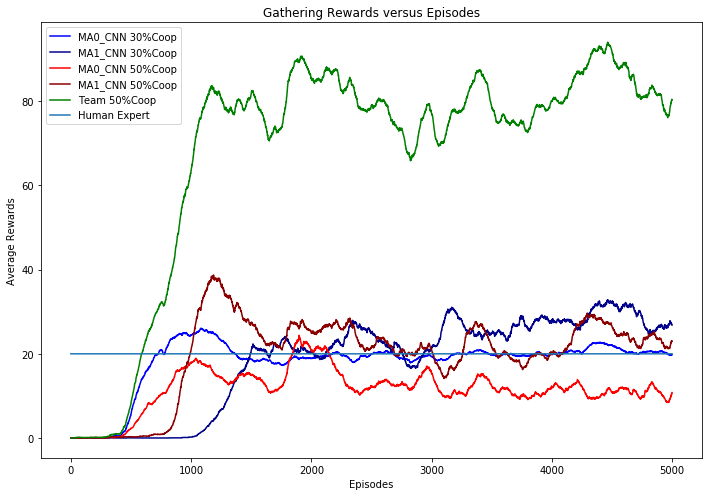

In [16]:
human_scores = {'Gathering': 20}
game = 'Gathering'

dir_name = "results/MA_4L1R_Coop/"

data_file = dir_name+'MA0_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_0 = pickle.load(f)

   
data_file = dir_name+'MA1_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_1 = pickle.load(f)


data_file = dir_name+'MA2_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_2 = pickle.load(f)

   
data_file = dir_name+'MA3_Gather.p'.format(game)

with open(data_file, 'rb') as f:
    data_3 = pickle.load(f)


total = [sum(x) for x in zip(data_0,data_1,data_2,data_3)]


print('Max. Running Reward - MA0 3-layer CNN Coop-30%: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA1 3-layer CNN Coop-30%: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))

print('Max. Running Reward - MA2 3-layer CNN Coop-50%: {:.3f}'.format(max(data_0)))
print('Episode achieving max. Running Reward: {}'.format(data_0.index(max(data_0))))
print('Max. Running Reward - MA3 3-layer CNN Coop-50%: {:.3f}'.format(max(data_1)))
print('Episode achieving max. Running Reward: {}'.format(data_1.index(max(data_1))))



human = [human_scores[game] for _ in range(len(data_0))]

plt.figure(figsize=(10, 7))
plt.plot(data_0, label='MA0_CNN 30%Coop', color='b')
plt.plot(data_1, label='MA1_CNN 30%Coop', color='darkblue')
plt.plot(data_2, label='MA0_CNN 50%Coop', color='red')
plt.plot(data_3, label='MA1_CNN 50%Coop', color='darkred')
plt.plot(total, label='Team 50%Coop', color='green')

plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Training Section

This is the code for training the agents. The procedure is to first modify the finish_episode() to set the reward structure for the agents, run it. Then we run this code section to perform the actual training.

In [ ]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   9 agents - 8 learning agents, 0 trained agents, 1 random agents
num_learners = 8
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
env = GatheringEnv(n_agents=num_agents, map_name='default')   # 2 agents, used map defined in default.txt 
num_actions = 8                       # 8 actions in Gathering

#   Data structure for agents
agents = []
actions = []
log_probs = []
tags = []
rewards = []
optimizers = []

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 5000
max_frames = 300
max_frames_ep = 0   # track highest number of frames an episode can last
# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 50
save_interval = 500



def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""

def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 



# The main code starts here!!!


# Cold start
if warm_start is False:
   
    # Initialize learner agents, then load static agents (trained followed by random)
    for i in range(num_learners):
        print("Learner agent {}".format(i+1))
        agents.append(Policy(num_frames, num_actions, i+1)) # No weights loaded for learning agent
        optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
        # set up optimizer - this works for Atari Breakout
        # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
    for i in range(num_learners, num_learners+num_trained):
        print ("No trained agent exist yet!")
        raise
        """
        Disable for now! No trained model exist!!!
        agents.append(Policy(num_frames, num_actions, i+1))
        agents[i].load_weights()         # load weight for static agent        
        """
    for i in range(num_learners+num_trained, num_agents):
        print("Load random agent {}".format(i+1))
        agents.append(Rdn_Policy())

    
    # Initialize all agent data
    for i in range(num_agents):
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]
        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

    # This is to support warm start for training
    prior_eps = 0

# Warm start
if warm_start:
    print ("Cannot warm start")
    raise
    
    """
    # Disable for now!  Need to ensure model can support training on GPU and game playing
    # on both CPU and GPU.
    
    data_file = 'results/{}.p'.format(game)

    try:
        with open(data_file, 'rb') as f:
            running_rewards = pickle.load(f)
            running_reward = running_rewards[-1]

        prior_eps = len(running_rewards)

        model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
        with open(model_file, 'rb') as f:
            # Model Save and Load Update: Include both model and optim parameters
            saved_model = pickle.load(f)
            model, optimizer = saved_model

    except OSError:
        print('Saved file not found. Creating new cold start model.')
        model = Policy(input_channels=num_frames, num_actions=num_actions)
        optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
        running_rewards = []
        prior_eps = 0
    """

    
    
cuda = torch.cuda.is_available()

if cuda:
    for i in range(num_learners):    # Learning agents need to utilize GPU
        agents[i].cuda()

        
for ep in range(max_episodes):
    
    # Anneal temperature from temp_start to temp_end
    for i in range(num_learners):    # For learning agents
        agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

    env_obs = env.reset()  # Env return observations

    # For Debug only
    # print (len(env_obs))
    # print (env_obs[0].shape)
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)

    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # LSTM change - reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    if cuda:
        cx = cx.cuda()
        hx = hx.cuda()
    """

    episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
    for frame in range(max_frames):

        """
        For now, we do not implement LSTM
        # Select action
        # LSTM Change: Need to cycle hx and cx thru select_action
        action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
        """

        for i in range(num_learners):    # For learning agents
            actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
            agents[i].saved_actions.append((log_probs[i]))
            
            # Do not implement LSTM for now
            # actions[i].saved_actions.append((log_prob, value))
            
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
        for i in range(num_learners+num_trained, num_agents):   # For random agents
            actions[i] = agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness

        # For Debug only
        # if frame % 20 == 0:
        #    print (actions) 
        #    print (log_probs)
            
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """
       
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        # For learner agents only, generate reward statistics and reward stack for policy gradient
        for i in range(num_learners):
            agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
            episode_reward[i] += reward[i]   # accumulate episode reward 
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """

        if any(done):
            print("Done after {} frames".format(frame))
            break
            
    if frame > max_frames_ep:
        max_frames_ep = frame    # Keep track of highest frames/episode

    # Update reward statistics for learners
    for i in range(num_learners):
        if running_reward[i] is None:
            running_reward[i] = episode_reward[i]
        running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
        running_rewards[i].append(running_reward[i])

    # Track Episode #, temp and highest frames/episode
    if (ep+prior_eps+1) % log_interval == 0: 
        verbose_str = 'Episode {} complete'.format(ep+prior_eps+1)
        # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
        # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
        print(verbose_str)
    
        # Display rewards and running rewards for learning agents
        for i in range(num_learners):
            verbose_str = 'Learner:{}'.format(i)
            verbose_str += '\tReward total:{}'.format(episode_reward[i])
            verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
            print(verbose_str)
    
    # Update model
    total_norm = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

    if (ep+prior_eps+1) % log_interval == 0: 
        verbose_str = 'Max Norm = {}'.format(total_norm)    # Keep track of highest frames/episode
        print(verbose_str)
        
    if (ep+prior_eps+1) % save_interval == 0: 
        for i in range(num_learners):

            model_file = 'MA_models/MA{}_{}_ep_{}.p'.format(i, game, ep+prior_eps+1)
            data_file = 'results/MA{}_{}.p'.format(i, game)
            with open(model_file, 'wb') as f:
                # Model Save and Load Update: Include both model and optim parameters 
                pickle.dump((agents[i].cpu(), optimizers[i]), f)

            if cuda:
                agents[i] = agents[i].cuda()

            with open(data_file, 'wb') as f:
                pickle.dump(running_rewards[i], f)    
        
    """
    Do not save model for now!!!
    if (ep+prior_eps+1) % 500 == 0: 
        model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(
                                                                game,
                                                                ep+prior_eps+1)
        data_file = 'results/{}.p'.format(game)
        with open(model_file, 'wb') as f:
            # Model Save and Load Update: Include both model and optim parameters 
            pickle.dump((model.cpu(), optimizer), f)

        if cuda:
            model = model.cuda()

        with open(data_file, 'wb') as f:
            pickle.dump(running_rewards, f)    
    """

            
env.close()  # Close the environment


Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Learner agent 8
Load random agent 9
Episode 50 complete
Learner:0	Reward total:0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.0
Learner:5	Reward total:0	Running mean: 0.0
Learner:6	Reward total:0	Running mean: 0.1683
Learner:7	Reward total:0	Running mean: 0.1923
Max Norm = 0.0
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.0481
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.0
Learner:5	Reward total:0	Running mean: 0.1182
Learner:6	Reward total:0	Running mean: 0.2452
Learner:7	Reward total:0	Running mean: 0.1559
Max Norm = 0.0
Episode 150 complete
Learner:0	Reward total:0	Running mean: 0.0291
Learner:

Max Norm = 121.06693080577287
Episode 1050 complete
Learner:0	Reward total:49	Running mean: 27.01
Learner:1	Reward total:0	Running mean: 0.0004024
Learner:2	Reward total:0	Running mean: 1.275e-05
Learner:3	Reward total:0	Running mean: 0.1087
Learner:4	Reward total:0	Running mean: 0.4854
Learner:5	Reward total:21	Running mean: 13.1
Learner:6	Reward total:18	Running mean: 17.38
Learner:7	Reward total:13	Running mean: 18.29
Max Norm = 77.94113690320441
Episode 1100 complete
Learner:0	Reward total:9	Running mean: 27.15
Learner:1	Reward total:2	Running mean: 0.02024
Learner:2	Reward total:0	Running mean: 7.712e-06
Learner:3	Reward total:1	Running mean: 0.3043
Learner:4	Reward total:9	Running mean: 1.518
Learner:5	Reward total:17	Running mean: 12.89
Learner:6	Reward total:20	Running mean: 18.46
Learner:7	Reward total:25	Running mean: 20.97
Max Norm = 96.26758297943177
Episode 1150 complete
Learner:0	Reward total:45	Running mean: 27.55
Learner:1	Reward total:0	Running mean: 0.01979
Learner:2	

In [74]:
reward = [[] for i in range(3)]

reward[0] = [1,1,1,1,1]
reward[1] = [2,1,2,1,2]
reward[2] = [1,3,3,13,1]


sum = np.array([0,0,0,0,0]) 

for i in range(3):
    sum = sum + np.array(reward[i])

print (sum)

for i in range(3):
    rewards = []
    R=0
    for r,S in zip(reward[i][::-1], sum[::-1]):
            Coop = S/10
            print (r, Coop)
            R = r + Coop + 0.9 * R
            rewards.append(R)
    print (rewards)


[ 4  5  6 15  4]
1 0.4
1 1.5
1 0.6
1 0.5
1 0.4
[1.4, 3.76, 4.984, 5.9856, 6.787039999999999]
2 0.4
1 1.5
2 0.6
1 0.5
2 0.4
[2.4, 4.66, 6.7940000000000005, 7.6146, 9.25314]
1 0.4
13 1.5
3 0.6
3 0.5
1 0.4
[1.4, 15.76, 17.784, 19.5056, 18.95504]


### Figure out torch.Tensor's permute()

In [53]:
x = np.array([[[0,1,2,3],[4,5,6,7],[8,9,0,1]],[[10,11,12,13],[14,15,16,17],[18,19,10,11]]])
print (x.shape)
print(x[0,1,:])
print(x)


x = torch.Tensor(x)
x = x.permute(2,0,1)

print (x.shape)
print(x[2,:,:])
print(x)

(2, 3, 4)
[4 5 6 7]
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9  0  1]]

 [[10 11 12 13]
  [14 15 16 17]
  [18 19 10 11]]]
torch.Size([4, 2, 3])
tensor([[ 2.,  6.,  0.],
        [12., 16., 10.]])
tensor([[[ 0.,  4.,  8.],
         [10., 14., 18.]],

        [[ 1.,  5.,  9.],
         [11., 15., 19.]],

        [[ 2.,  6.,  0.],
         [12., 16., 10.]],

        [[ 3.,  7.,  1.],
         [13., 17., 11.]]])


In [86]:
def unpack_env_obs(env_obs):
    
    num_agents = len(env_obs)  # environ observations is a list of observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the observation of the indexed agent
        x = torch.Tensor(x)   # Convert to tensor
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stack frames
        obs.append(x)
        
    return obs



print(len(observs))
print (observs[0].shape)

agent_obs = unpack_env_obs(observs)
print(len(agent_obs))
print (agent_obs[0].shape)

4
(800,)
4
torch.Size([1, 4, 10, 20])


### Dataflow for Atari Code

For the original code implementing Actor-Critic for Atari games.

The environment return a state of format (210, 160, 3). This is preprocessed to (80, 80) single frame. 4 frames are then stacked together.

The state that is accepted by Policy is (4,80,80).

In [94]:
import numpy as np


def preprocess_state(state):
    # preprocess 210x160x3 uint8 frame into 80x80 2D float array
    # https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5
    state = state[35:195]  # crop to 160 x 160 x 3
    state = convert_rgb_to_grayscale(state)
    state = state[::2, ::2]  # downsample by factor of 2
    return state.astype(float).reshape(80, 80)


def convert_rgb_to_grayscale(rgb):
    rgb = np.array(rgb)
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

game='Pong-v0'
env = gym.make(game)
num_actions = env.action_space.n
num_frames = 4

model = Policy(input_channels=num_frames, num_actions=num_actions)

state = env.reset()
print (state.shape)
state = preprocess_state(state)
print (state.shape)
state = np.stack([state]*num_frames)
print (state.shape)

[2018-11-13 18:08:05,934] Making new env: Pong-v0


(210, 160, 3)
(80, 80)
(4, 80, 80)


In [52]:
print (agents[0:num_learners])
print (optimizers[0:num_learners])

[Policy(
  (features): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
  )
  (action_head): Linear(in_features=384, out_features=8, bias=True)
), Policy(
  (features): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, a

In [90]:
model_file = 'MA_models/MA1_Gather_ep_5000.p'
with open(model_file, 'rb') as f:
    # Model File include both model and optim parameters
    saved_model = pickle.load(f)
    print (saved_model)
    model, _ = saved_model
    print (model)

(Policy(
  (features): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
  )
  (action_head): Linear(in_features=384, out_features=8, bias=True)
), RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0.1
))
Policy(
  (features): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(i